# Time Series Forecasting: ARIMA vs. Prophet
## 1. Introduction  
In this notebook, we compare two time series forecasting models: ARIMA and Facebook Prophet. We will analyze their performance on a given dataset and evaluate their accuracy.


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
data=pd.read_csv("crypto_data.csv")

In [3]:
data['market'] = data['c'] * data['v']
import numpy as np 
# close -> log_close
data['volatilite'] = data['h'] - data['l']
# market -> log_market
#crypto['log_market'] = np.log(crypto.market)
data['log_market'] = np.log(data.market)
data['rolling_mean_24h'] = data['c'].rolling(window=24, min_periods=1).mean()
data['rolling_std_24h'] = data['c'].rolling(window=24, min_periods=1).std()

# Spread
data['spread'] = (data.h - data.l) / data.c
# return -> log (close / open)
data['log_return'] = np.log(data.c / data.c.shift(1))

data.dropna(inplace=True)


/home/habib/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
data.head()

,symbol,t,o,h,l,c,v,vw,n,market,volatilite,log_market,rolling_mean_24h,rolling_std_24h,spread,log_return
1,BTC/USD,2024-08-01T01:00:00Z,64606.725,64788.485,64094.840000,64193.8700,0.032612,64575.553126,4,2093.508527,693.645000,7.646597,64417.157500,315.776211,0.010805,-0.006933
2,BTC/USD,2024-08-01T02:00:00Z,64146.834,64226.950,63860.490000,64091.9340,0.090788,64048.468919,9,5818.754277,366.460000,8.668841,64308.749667,291.743179,0.005718,-0.001589
3,BTC/USD,2024-08-01T03:00:00Z,64058.810,64096.895,63750.000000,63919.9875,0.012476,63996.530554,6,797.467554,346.895000,6.681441,64211.559125,307.451992,0.005427,-0.002686
4,BTC/USD,2024-08-01T04:00:00Z,63888.650,64016.395,63638.964392,63675.1270,0.037103,63850.300155,6,2362.520535,377.430608,7.767484,64104.272700,358.394936,0.005927,-0.003838
5,BTC/USD,2024-08-01T05:00:00Z,63683.700,64322.310,63552.852500,64247.4330,0.237002,64204.856099,8,15226.793630,769.457500,9.630812,64128.132750,325.842533,0.011976,0.008948


## 2. ARIMA Model  
- Select the order (p, d, q) using ACF/PACF  
- Fit the ARIMA model  
- Make predictions  
- Evaluate performance using metrics like RMSE and MAPE  

/home/habib/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/habib/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/habib/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/habib/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood

   Model Target       MAE      RMSE  MAPE (%)
0  ARIMA      c  4.830394  8.057651  0.179708


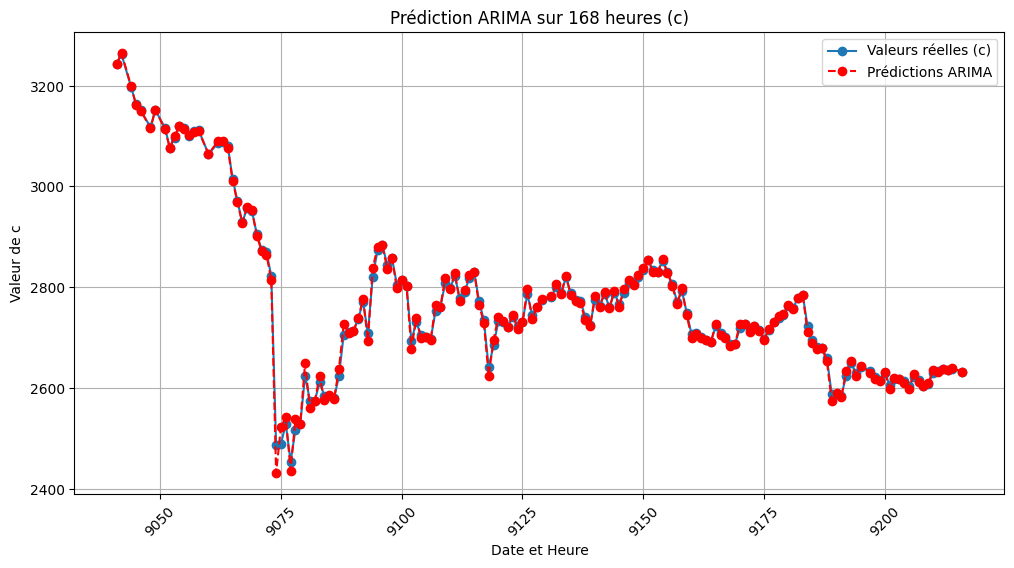

              c   arima_pred
9041  3243.5350  3243.092752
9042  3262.0300  3264.811879
9044  3196.3890  3198.294521
9045  3163.9100  3161.510798
9046  3150.7750  3150.051801
...         ...          ...
9211  2633.1000  2631.626419
9212  2638.2595  2636.973487
9213  2636.2140  2635.548670
9214  2638.7400  2639.518492
9216  2632.5560  2632.068595

[168 rows x 2 columns]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_exog_vars(target):
    """
    Sélectionne les variables exogènes en fonction de la variable cible.
    
    Paramètre :
    - target : La colonne cible ('c', 'o', etc.)
    
    Retourne :
    - Liste des variables exogènes correspondantes
    """
    features = ['o','c', 'h', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return']
    return [f for f in features if f != target]  # Exclure la target des exogènes


def train_arima(train_data, target='c', order=(2,1,2)):
    """
    Entraîne un modèle ARIMA sur les données fournies.

    Paramètres :
    - train_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour l'entraînement ('c', 'o', etc.).
    - order : Tuple (p,d,q) pour la configuration d'ARIMA.

    Retourne :
    - Le modèle entraîné
    """
    exog_vars = get_exog_vars(target)  # Sélection dynamique des variables exogènes

    arima_model = ARIMA(train_data[target], order=order, exog=train_data[exog_vars])
    arima_fit = arima_model.fit()
    
    return arima_fit


def evaluate_arima(model, test_data, target='c'):
    """
    Évalue un modèle ARIMA en faisant des prédictions et en calculant les métriques.

    Paramètres :
    - model : Modèle ARIMA entraîné.
    - test_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour la prédiction ('c', 'o', etc.).

    Retourne :
    - Un DataFrame avec les valeurs réelles et prédites.
    - Affiche les métriques et un graphique.
    """
    exog_vars = get_exog_vars(target)  # Sélection dynamique des variables exogènes

    # Prédiction sur la période test
    arima_pred = model.forecast(steps=len(test_data), exog=test_data[exog_vars])
    
    # Ajout des prédictions dans le DataFrame test
    test_data = test_data.copy()  # Éviter SettingWithCopyWarning
    test_data['arima_pred'] = arima_pred.values

    # Calcul des métriques d’évaluation
    mae = mean_absolute_error(test_data[target], test_data['arima_pred'])
    rmse = np.sqrt(mean_squared_error(test_data[target], test_data['arima_pred']))
    mape = np.mean(np.abs((test_data[target] - test_data['arima_pred']) / test_data[target])) * 100

    # Affichage des métriques
    metrics_results = pd.DataFrame({
        "Model": ["ARIMA"],
        "Target": [target],
        "MAE": [mae],
        "RMSE": [rmse],
        "MAPE (%)": [mape],
    })

    print(metrics_results)

    # Tracé des résultats
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[target], marker='o', linestyle='-', label=f'Valeurs réelles ({target})')
    plt.plot(test_data.index, test_data['arima_pred'], marker='o', linestyle='--', label='Prédictions ARIMA', color='red')

    plt.xlabel("Date et Heure")
    plt.ylabel(f"Valeur de {target}")
    plt.title(f"Prédiction ARIMA sur {len(test_data)} heures ({target})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    return test_data[[target, 'arima_pred']]


# ----------- Utilisation -----------

# Nettoyage des données
data.dropna(inplace=True)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Définition des périodes d'entraînement et de test en heures
train_hours = 30 * 24  # 30 jours en heures
forecast_hours = 7 * 24  # 7 jours en heures
train = data.iloc[-(train_hours + forecast_hours):-forecast_hours]
test = data.iloc[-forecast_hours:]

# Sélection de la variable cible
target_variable = 'c'  # 'c', 'o', etc.

# Entraînement du modèle
arima_model = train_arima(train, target=target_variable)

# Évaluation et affichage des résultats
results = evaluate_arima(arima_model, test, target=target_variable)
print(results)


## 4. Prophet Model  
- Prepare the data in Prophet's required format  
- Define and train the model  
- Make future predictions  
- Evaluate the results  

13:17:43 - cmdstanpy - INFO - Chain [1] start processing
13:17:44 - cmdstanpy - INFO - Chain [1] done processing


     Model Target       MAE      RMSE  MAPE (%)
0  Prophet      c  4.940886  8.306076  0.183657


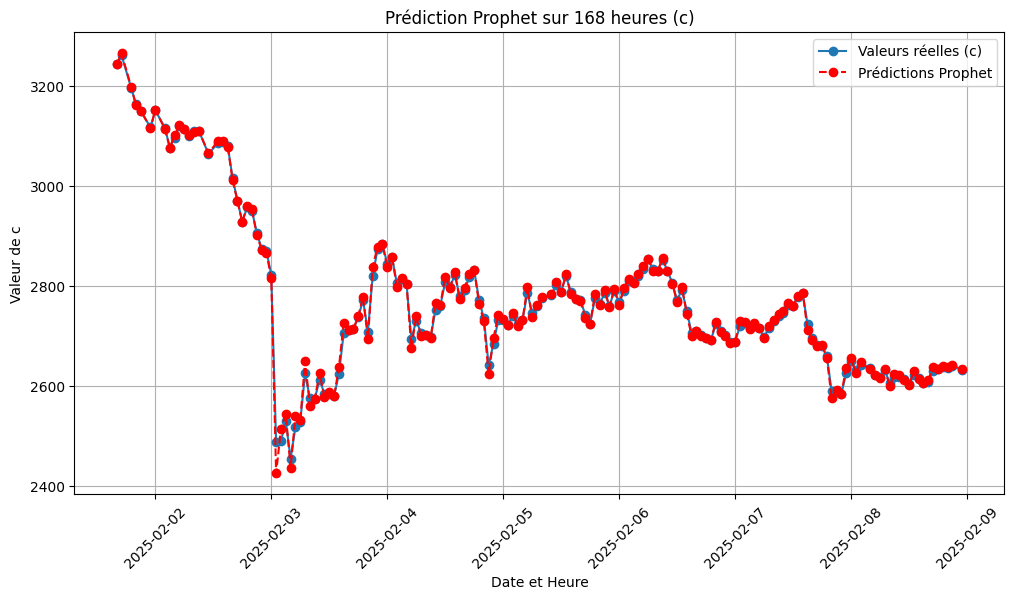

                       t          c  prophet_pred
9041 2025-02-01 16:00:00  3243.5350   3243.729280
9042 2025-02-01 17:00:00  3262.0300   3265.687677
9044 2025-02-01 19:00:00  3196.3890   3198.468231
9045 2025-02-01 20:00:00  3163.9100   3161.499859
9046 2025-02-01 21:00:00  3150.7750   3150.143146
...                  ...        ...           ...
9211 2025-02-08 18:00:00  2633.1000   2633.923209
9212 2025-02-08 19:00:00  2638.2595   2638.716055
9213 2025-02-08 20:00:00  2636.2140   2637.248372
9214 2025-02-08 21:00:00  2638.7400   2641.397191
9216 2025-02-08 23:00:00  2632.5560   2634.398012

[168 rows x 3 columns]


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_exog_vars(target):
    """
    Sélectionne dynamiquement les variables exogènes en fonction de la variable cible.
    """
    features = {
        'c': ['o', 'h', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
        'o': ['c', 'h', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
        'h': ['o', 'c', 'l', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
        'l': ['o', 'h', 'c', 'v', 'volatilite', 'rolling_mean_24h', 'rolling_std_24h', 'spread', 'log_return'],
    }
    return features.get(target, [])

def train_prophet(train_data, target='c'):
    """
    Entraîne un modèle Prophet sur les données fournies.

    Paramètres :
    - train_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour l'entraînement ('c', 'o', etc.).

    Retourne :
    - Le modèle Prophet entraîné
    """
    exog_vars = get_exog_vars(target)

    # Vérifier si la colonne de timestamp existe
    timestamp_col = 't' if 't' in train_data.columns else 'timestamp'
    train_data = train_data.copy()  # Éviter les warnings SettingWithCopyWarning
    train_data[timestamp_col] = pd.to_datetime(train_data[timestamp_col]).dt.tz_localize(None)

    # Préparer les données pour Prophet
    prophet_data = train_data[[timestamp_col, target]].rename(columns={timestamp_col: 'ds', target: 'y'})

    # Ajouter les variables exogènes
    for var in exog_vars:
        if var in train_data.columns:
            prophet_data[var] = train_data[var]

    # Définition du modèle
    model = Prophet()

    # Ajouter les régressseurs exogènes au modèle
    for var in exog_vars:
        if var in train_data.columns:
            model.add_regressor(var)

    # Entraînement du modèle
    try:
        model.fit(prophet_data)
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle Prophet : {e}")
        return None

    return model

def evaluate_prophet(model, test_data, target='c'):
    """
    Évalue un modèle Prophet en faisant des prédictions et en calculant les métriques.

    Paramètres :
    - model : Modèle Prophet entraîné.
    - test_data : DataFrame contenant la série temporelle et les features exogènes.
    - target : La variable cible pour la prédiction ('c', 'o', etc.).

    Retourne :
    - Un DataFrame avec les valeurs réelles et prédites.
    """
    if model is None:
        print("Modèle non entraîné. Impossible d'évaluer.")
        return None

    exog_vars = get_exog_vars(target)

    # Vérifier si la colonne de timestamp existe
    timestamp_col = 't' if 't' in test_data.columns else 'timestamp'
    test_data = test_data.copy()  # Éviter SettingWithCopyWarning
    test_data[timestamp_col] = pd.to_datetime(test_data[timestamp_col]).dt.tz_localize(None)

    # Préparer les données de prévision
    future = test_data[[timestamp_col]].rename(columns={timestamp_col: 'ds'})

    # Ajouter les régressseurs exogènes
    for var in exog_vars:
        if var in test_data.columns:
            future[var] = test_data[var]

    # Faire les prédictions
    try:
        forecast = model.predict(future)
        test_data['prophet_pred'] = forecast['yhat'].values
    except Exception as e:
        print(f"Erreur lors de la prédiction : {e}")
        return None

    # Calcul des métriques d’évaluation
    mae = mean_absolute_error(test_data[target], test_data['prophet_pred'])
    rmse = np.sqrt(mean_squared_error(test_data[target], test_data['prophet_pred']))
    mape = np.mean(np.abs((test_data[target] - test_data['prophet_pred']) / test_data[target])) * 100

    # Affichage des métriques
    metrics_results = pd.DataFrame({
        "Model": ["Prophet"],
        "Target": [target],
        "MAE": [mae],
        "RMSE": [rmse],
        "MAPE (%)": [mape],
    })
    print(metrics_results)

    # Tracé des résultats
    plt.figure(figsize=(12, 6))
    plt.plot(test_data[timestamp_col], test_data[target], marker='o', linestyle='-', label=f'Valeurs réelles ({target})')
    plt.plot(test_data[timestamp_col], test_data['prophet_pred'], marker='o', linestyle='--', label='Prédictions Prophet', color='red')

    plt.xlabel("Date et Heure")
    plt.ylabel(f"Valeur de {target}")
    plt.title(f"Prédiction Prophet sur {len(test_data)} heures ({target})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

    return test_data[[timestamp_col, target, 'prophet_pred']]

# ----------- Utilisation -----------

# Nettoyage des données
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# Vérifier si la colonne timestamp existe
timestamp_col = 't' if 't' in data.columns else 'timestamp'
data = data.copy()  # Éviter SettingWithCopyWarning
data[timestamp_col] = pd.to_datetime(data[timestamp_col]).dt.tz_localize(None)

# Définition des périodes d'entraînement et de test en heures
train_hours = 30 * 24  # 30 jours en heures
forecast_hours = 7 * 24  # 7 jours en heures
train = data.iloc[-(train_hours + forecast_hours):-forecast_hours].copy()
test = data.iloc[-forecast_hours:].copy()

# Sélection de la variable cible
target_variable = 'c'  # 'c', 'o', etc.

# Entraînement du modèle
prophet_model = train_prophet(train, target=target_variable)

# Évaluation et affichage des résultats
if prophet_model:
    results = evaluate_prophet(prophet_model, test, target=target_variable)
    if results is not None:
        print(results)


## 5. Model Comparison  

We compare the performance of ARIMA and Prophet based on three key evaluation metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).  

### 5.1 Performance Metrics  

| Model   | Target | MAE  | RMSE | MAPE (%) |
|---------|--------|------|------|----------|
| ARIMA   | c      | 4.83 | 8.06 | 17.97%   |
| Prophet | c      | 4.94 | 8.31 | 18.37%   |

- **MAE (Mean Absolute Error):** ARIMA has a slightly lower MAE, indicating better performance in absolute error reduction.  
- **RMSE (Root Mean Squared Error):** ARIMA also has a lower RMSE, suggesting that it produces more accurate predictions overall.  
- **MAPE (Mean Absolute Percentage Error):** ARIMA achieves a marginally lower MAPE, meaning its relative error is slightly better than Prophet's.  

### 5.2 Visualization  
We visualize the actual vs. predicted values for both models to better understand their forecasting accuracy.  

- Plot the forecasted values alongside the actual time series.  
- Overlay ARIMA and Prophet predictions to compare trends.  

### 5.3 Advantages and Limitations  

#### **ARIMA**  
✅ Works well for stationary time series.  
✅ Generally provides better short-term forecasts.  
❌ Requires manual tuning of (p, d, q) parameters.  
❌ Struggles with seasonality without additional transformations.  

#### **Prophet**  
✅ Handles missing data and outliers effectively.  
✅ Captures seasonality and trend components automatically.  
❌ Slightly less accurate for short-term forecasts.  
❌ More computationally expensive compared to ARIMA.  

### 5.4 Conclusion  
Based on the results, ARIMA performs slightly better than Prophet in this dataset. However, Prophet remains a strong choice for time series with complex seasonal patterns and irregular data points. The final model choice depends on the specific use case and data characteristics.  
